In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
%pip install numpy torch

  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 7.3 MB/s eta 0:00:00
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 11.4 MB/s eta 0:00:0000:0100:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [51]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # tuple _children is saved in _prev as set
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # making it more readable
    def __repr__(self):
        return f"Value(data={self.data})"

    # regular addition using +
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # chain rule: local deriv * bigger deriv
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    # regular multiplication using *
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # chain out.grad into self.grad and other.grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other): # self * other
        return self * other

    def __truediv__(self, other): # self / other
        return self * other ** -1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out

    # e ** x
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            # chain rule; dy / dx (e ** x) = e ** x
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    

In [30]:
a = Value(2)
b = Value(3)

a - b

Value(data=-1)

In [31]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

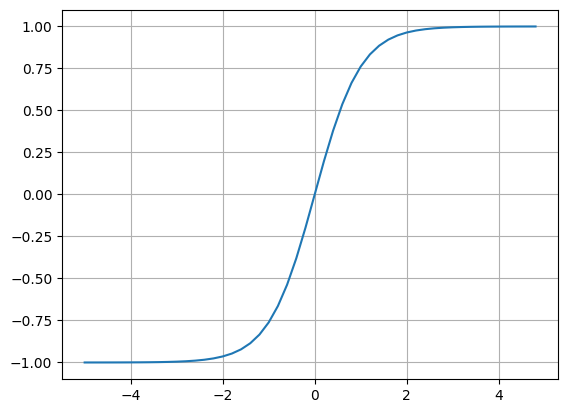

In [40]:
# activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [41]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.88137, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1 * w1'
x2w2 = x2 * w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

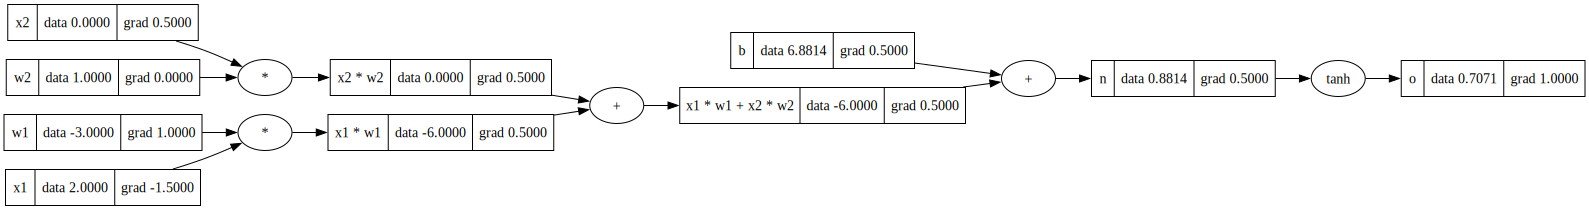

In [42]:
draw_dot(o)

Value(data=5.828385311532177)
Value(data=0.7071049876722272)


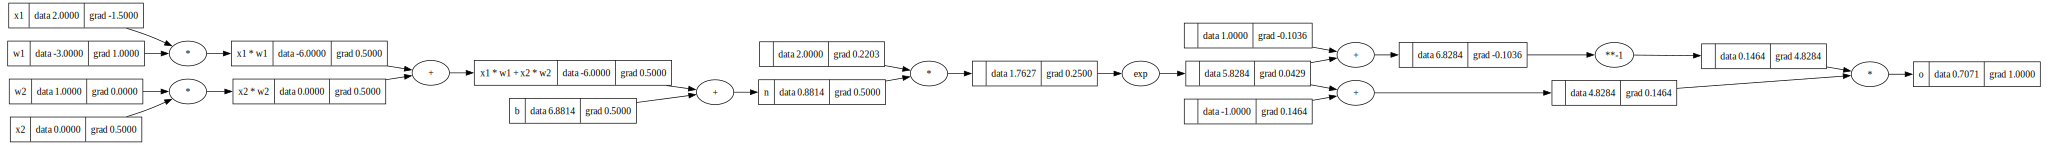

In [43]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.88137, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label='x1 * w1'
x2w2 = x2 * w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2 * n).exp()
print(e)
o = (e - 1) / (e + 1)
print(o)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

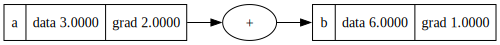

In [44]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [45]:
import torch

# setting dtype to float64 (.double())
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# gets item for a 1 element tensor
print(o.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071050214706146
----
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [119]:
class Neuron:
    """
    A single neuron in a neural network.

    Attributes:
        w (list of Value): Weights of the neuron.
        b (Value): Bias of the neuron.
    """
    def __init__(self, nin):
        """
        Initializes a Neuron with random weights and bias.

        Args:
            nin (int): Number of inputs to the neuron.
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """
        Computes the output of the neuron for a given input.

        Args:
            x (list of float): Input values.

        Returns:
            Value: The output of the neuron after applying the activation function.
        """
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    """
    A layer in a neural network consisting of multiple neurons.

    Attributes:
        neurons (list of Neuron): Neurons in the layer.
    """
    def __init__(self, nin, nout):
        """
        Initializes a layer with the specified number of neurons.

        Args:
            nin (int): Number of inputs to each neuron in the layer.
            nout (int): Number of neurons in the layer.
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        """
        Computes the output of the layer for a given input.

        Args:
            x (list of float): Input values.

        Returns:
            list of Value: Outputs from each neuron in the layer.
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    """
    A multi-layer perceptron consisting of multiple layers.

    Attributes:
        layers (list of Layer): Layers in the MLP.
    """
    def __init__(self, nin, nouts):
        """
        Initializes the MLP with the specified layer configuration.

        Args:
            nin (int): Number of inputs to the MLP.
            nouts (list of int): Number of neurons in each layer of the MLP.
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        """
        Computes the output of the MLP for a given input.

        Args:
            x (list of float): Input values.

        Returns:
            list of Value: Final output of the MLP.
        """
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [210]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [211]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [220]:
for k in range(33):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update, stochastic gradient descent
    for p in n.parameters():
        p.data += -0.03 * p.grad

    print(k, loss.data)

0 0.005405646742217059
1 0.005375790421435419
2 0.005346260324142097
3 0.0053170511619651094
4 0.005288157759698394
5 0.005259575052302398
6 0.0052312980819994095
7 0.0052033219954599075
8 0.005175642041076773
9 0.005148253566324162
10 0.0051211520151978815
11 0.0050943329257346175
12 0.005067791927606906
13 0.005041524739791376
14 0.005015527168307512
15 0.004989795104024803
16 0.004964324520535292
17 0.004939111472089991
18 0.004914152091596257
19 0.004889442588674579
20 0.004864979247772383
21 0.004840758426333134
22 0.004816776553018796
23 0.004793030125983617
24 0.004769515711198069
25 0.0047462299408206204
26 0.004723169511616227
27 0.004700331183419757
28 0.004677711777642982
29 0.004655308175823585
30 0.0046331173182149864
31 0.004611136202415469
32 0.0045893618820354205


In [221]:
ypred

[Value(data=0.9603706156743539),
 Value(data=-0.9791169716297341),
 Value(data=-0.9605572565744084),
 Value(data=0.9679524900006994)]